# Toy example to demonstrate the library

In this notebook we will train a Kolmogorov-Arnold Network (KAN) to approximate the function
$$
\begin{aligned}
    y &= exp(sin(x_1\pi) + x_2^2)\\
    x_1,x_2 &\in\left[-1, 1\right]
\end{aligned}
$$ 

In [1]:
import math

import torch
import torch.nn as nn

import tkan.nn as kann

import matplotlib.pyplot as plt

%matplotlib inline

torch.random.manual_seed(0)

First we must create a train and evaluation dataset for our training

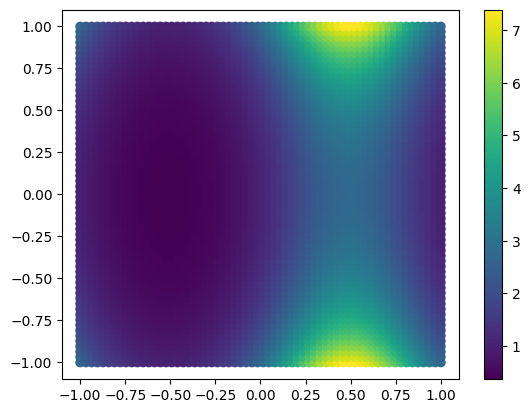

In [2]:
def f(x:torch.Tensor) -> torch.Tensor:
    return torch.exp(torch.sin(math.pi * x[:, 0]) + x[:, 1]**2)

with torch.no_grad():
    x_train = torch.empty((128, 2)).uniform_(-1, 1)
    y_train = f(x_train)

    xx, yy = torch.meshgrid(torch.linspace(-1, 1, 64), torch.linspace(-1, 1, 64), indexing='ij')
    x_val = torch.stack([xx, yy], dim=-1).view(-1, 2)
    y_val = f(x_val)

plt.scatter(x_val[:, 0], x_val[:, 1], c=y_val)
plt.colorbar()
plt.show()

## Initializing a KAN

We implement a variety of *KAN* layers in this library. Similar to a normal Linear layer in a Multi Layer Perceptron (MLP), they take a number of input features $m$ and map them to $n$ output features:
$$
L_{KAN}: \mathbb{R}^n\rightarrow\mathbb{R}^m
$$

A neuron in a KAN layer is far more expressive compared to a standard "linear" neuron, which is just a sum of weighted input values.
In contrast a can neuron passes each input $x_i$ through a learnable function $\phi_i: \mathbb{R}\rightarrow\mathbb{R}$ and outputs the sum of all function results:
$$
L_{KAN}(x)\rvert_j = \sum_{i=1}^m \phi_i(x_i)
$$ 
KAN networks are usually much more shallow compared to MLPs. This is due to the increased expressiveness of each single neuron and the inherent non-linearity encoded in the weight functions $\phi$.

Let's start with a very small KAN network with a single hidden layer mapping the two input features to 1 dimension. Since the implemented layers are just *nn.Modules* we can train a KAN like any other pytorch model. 

#Trainable Parameters: 13
Epoch 1000: 7.271e-03 - 1.344e-02


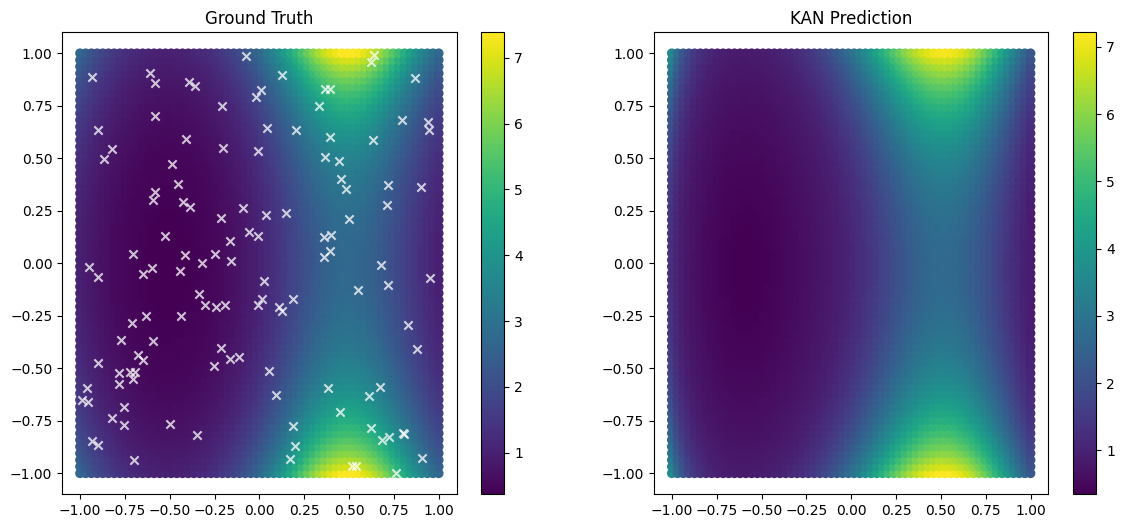

In [3]:
model = nn.Sequential(
   kann.LegendreKan(2, 1, order=4),
   kann.LegendreKan(1, 1, order=3) 
)

print(f"#Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.MSELoss()


epochs = 1000
for epoch in range(epochs):
   model.train()
   y_pred = model(x_train).squeeze(-1)
   loss = criterion(y_pred, y_train)

   optimizer.zero_grad()
   loss.backward()
   optimizer.step()


   if epoch % 10 == 0 or epoch == epochs - 1:
      model.eval()
      with torch.no_grad():
         y_pred = model(x_val).squeeze(-1)
         val_loss = criterion(y_pred, y_val)
      print(f"\rEpoch {epoch+1:4d}: {loss.item():.3e} - {val_loss.item():.3e}", end="")
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
c = ax1.scatter(x_val[:, 0], x_val[:, 1], c=y_val)
ax1.scatter(x_train[:, 0], x_train[:, 1], color='white', marker='x', alpha=0.75)
fig.colorbar(c, ax=ax1)
ax1.set_title("Ground Truth")
c = ax2.scatter(x_val[:, 0], x_val[:, 1], c=y_pred)
fig.colorbar(c, ax=ax2)
ax2.set_title("KAN Prediction")
plt.show()

## Visualizing learned KAN activations

In contrast to large weight matrices the trained activation functions $\phi$ can be visualized and interpreted. We can visualize the activations with the plotting module of the library.

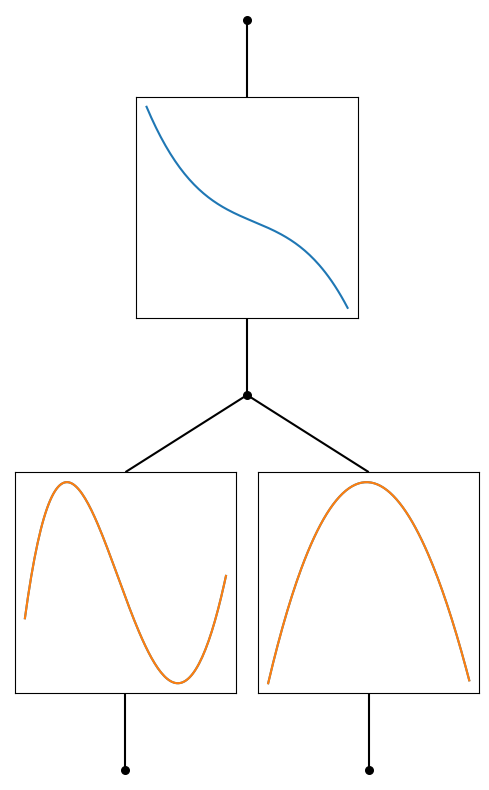

In [4]:
from tkan.plotting import plot_kan

fig = plt.figure(figsize=(6, 10))
plot_kan(model)
plt.show()

## KAN Layer Regularization

In the example above, we hand-crafted the KAN structure to match the target function. Usually, this is not possible, since the target is not kown. 
The authors of the original paper [[1]](https://arxiv.org/pdf/2404.19756) suggest to add L1 and entropy regularization to steer KANS toward a minimal number of active functions $\phi$.

We implement this loss in the *KanNodeSparsityLoss* class.

The activation functions $\phi$ can be arbitrarily complex. However, usually these mappings should be regularized in some form. For example if $\phi$ is a polynomial (e.g., in the LegendeKanLayer), a reasonable assumption is that order of the polynomial should be as low as possible.

The concrete regularization is up to the type of Kan layer, therefore the library exposes a *.regularization_loss()* method on the layers. We also supply a KanLayerRegularizationLoss that gathers all the losses in your model.

#Trainable Parameters: 13
Epoch 2000: loss 3.901e-02 - sparsity_loss 3.372e+00 - val_loss 5.158e-02


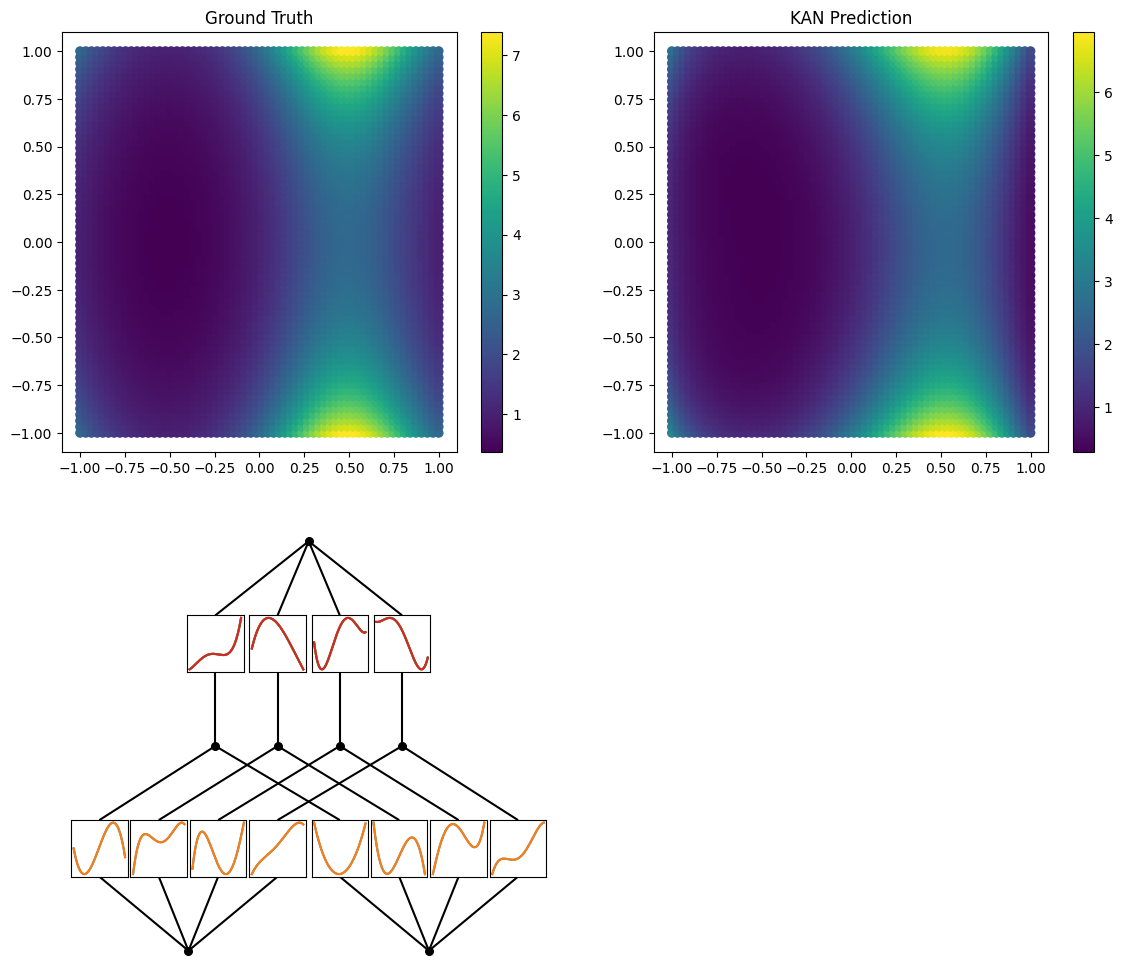

In [5]:
from tkan.training.losses import KanNodeSparsityLoss, KanLayerRegularizationLoss

def model_factory():
    return nn.Sequential(
        kann.LegendreKan(2, 4, order=4),
        kann.LegendreKan(4, 1, order=4),
    )

large_model = model_factory()
print(f"#Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.001)
criterion = nn.MSELoss()
reg_loss = KanNodeSparsityLoss(large_model)
reg_layer = KanLayerRegularizationLoss(large_model)
lambda_reg = 0.33
lambda_layer = 1e-3

epochs = 2000
for epoch in range(epochs):
    large_model.train()
    y_pred = large_model(x_train).squeeze(-1)
    loss = criterion(y_pred, y_train)
    sparsity_loss = reg_loss.compute()
    layer_loss = reg_layer.compute()

    total_loss = (loss + lambda_reg * sparsity_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()


    if epoch % 10 == 0 or epoch == epochs - 1:
        large_model.eval()
        with torch.no_grad():
            y_pred = large_model(x_val).squeeze(-1)
            val_loss = criterion(y_pred, y_val)
        print(f"\rEpoch {epoch+1:4d}: loss {loss.item():.3e} - sparsity_loss {sparsity_loss.item():.3e} - val_loss {val_loss.item():.3e}", end="")
print()

fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])

gs = fig.add_gridspec(2, 2)
c = ax1.scatter(x_val[:, 0], x_val[:, 1], c=y_val)
fig.colorbar(c, ax=ax1)
ax1.set_title("Ground Truth")
c = ax2.scatter(x_val[:, 0], x_val[:, 1], c=y_pred)
fig.colorbar(c, ax=ax2)
ax2.set_title("KAN Prediction")
plot_kan(large_model, ax=ax3, node_positions='compact')
plt.show()


## Pruning

The authors of [[1]](https://arxiv.org/pdf/2404.19756) suggest pruning neurons from the network if the incoming and outgoing activations $\phi$ are low.

Original model
Sequential(
  (0): LegendreKan[2, 4]
  (1): LegendreKan[4, 1]
)
Model after pruning
Sequential(
  (0): LegendreKan[2, 2]
  (1): LegendreKan[2, 1]
)
MSE: 5.158e-02 -> 2.326e-01


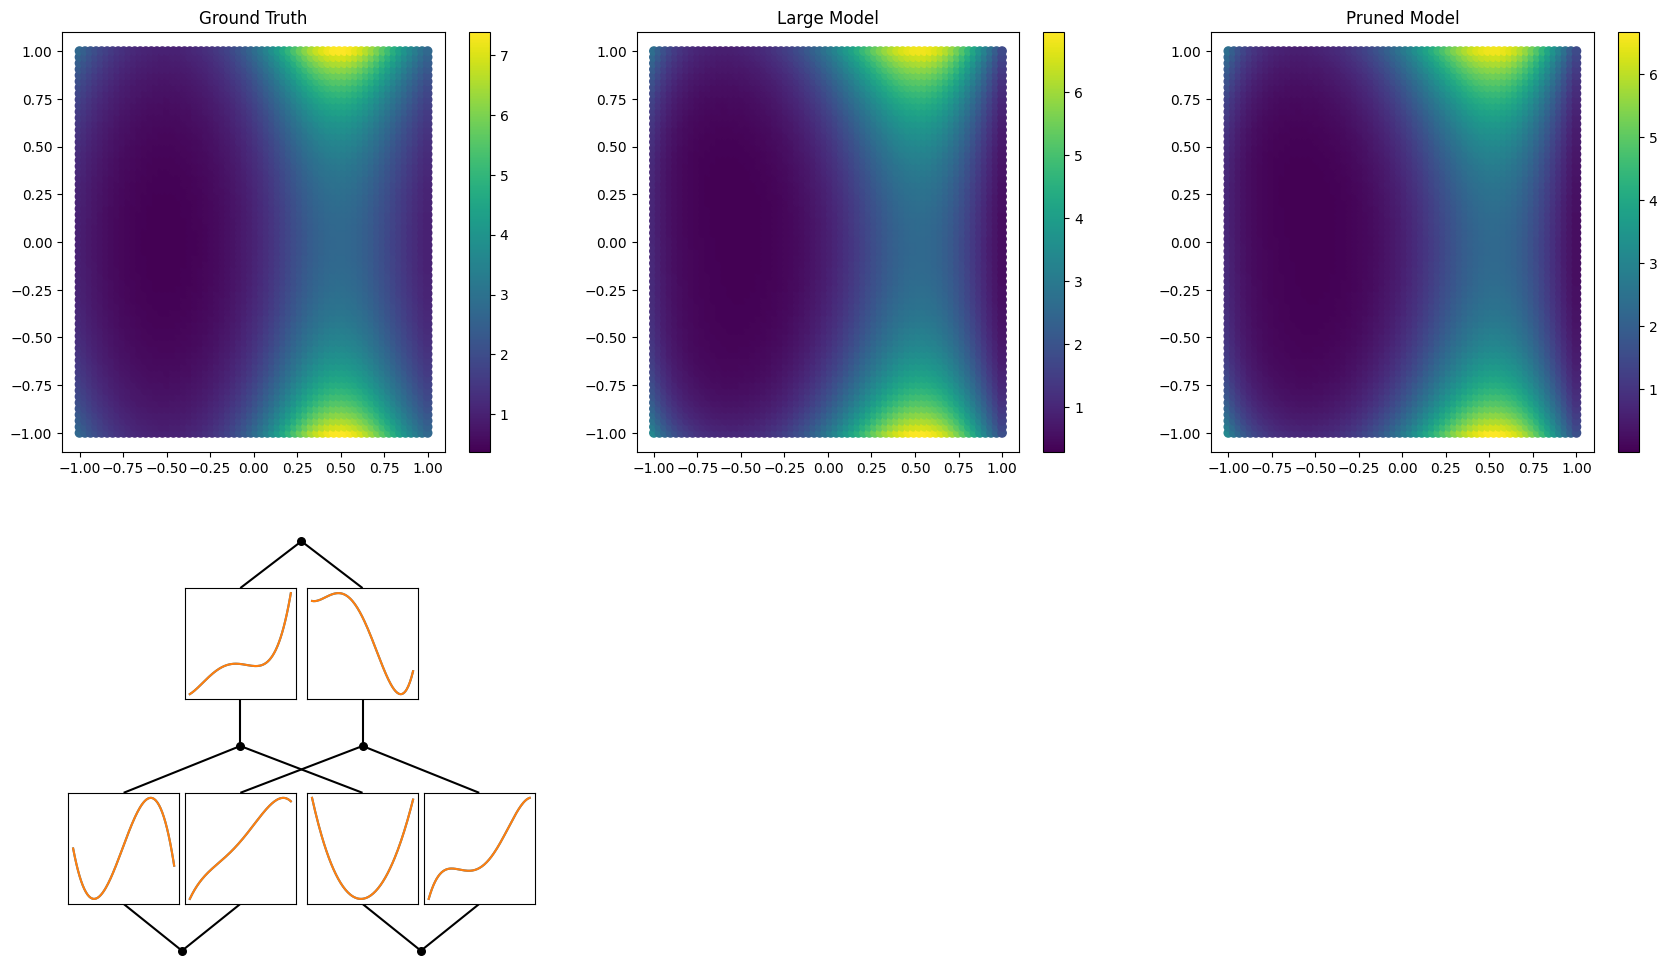

In [6]:
from tkan.training import prune_from_data

pruned_model = prune_from_data(
    model=large_model,
    data=x_val,
    theta=1e-2
)

print(f"Original model\n{large_model}")
print(f"Model after pruning\n{pruned_model}")

# Compute MSE after pruning
pruned_model.eval()
large_model.eval()
with torch.no_grad():
    y_pred_large = large_model(x_val).squeeze(-1)
    y_pred_pruned = pruned_model(x_val).squeeze(-1)
    prune_mse = (y_pred_pruned - y_val).square().mean()
    large_mse = (y_pred_large - y_val).square().mean()
    print(f"MSE: {large_mse.item():.3e} -> {prune_mse.item():.3e}")

fig = plt.figure(figsize=(21, 12))
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])

c = ax1.scatter(x_val[:, 0], x_val[:, 1], c=y_val)
fig.colorbar(c, ax=ax1)
ax1.set_title("Ground Truth")
c = ax2.scatter(x_val[:, 0], x_val[:, 1], c=y_pred_large)
fig.colorbar(c, ax=ax2)
ax2.set_title("Large Model")
c = ax3.scatter(x_val[:, 0], x_val[:, 1], c=y_pred_pruned)
fig.colorbar(c, ax=ax3)
ax3.set_title("Pruned Model")
plot_kan(pruned_model, ax=ax4, node_positions='compact')
plt.show()

After pruning we should retrain the model after the pruning. This time we can skip the sparsity regularization

Epoch  500: loss 9.166e-03 - val_loss 1.663e-02


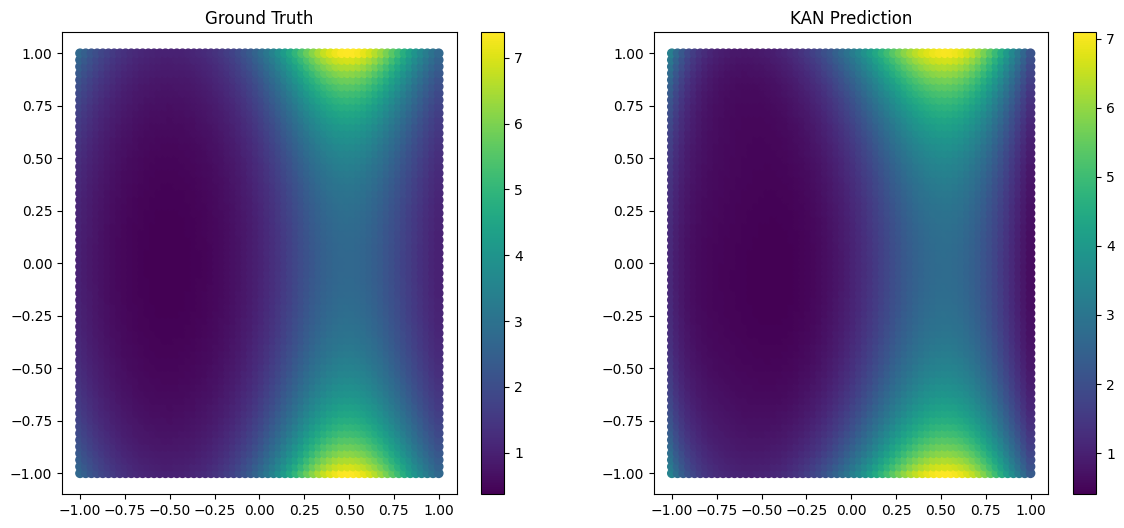

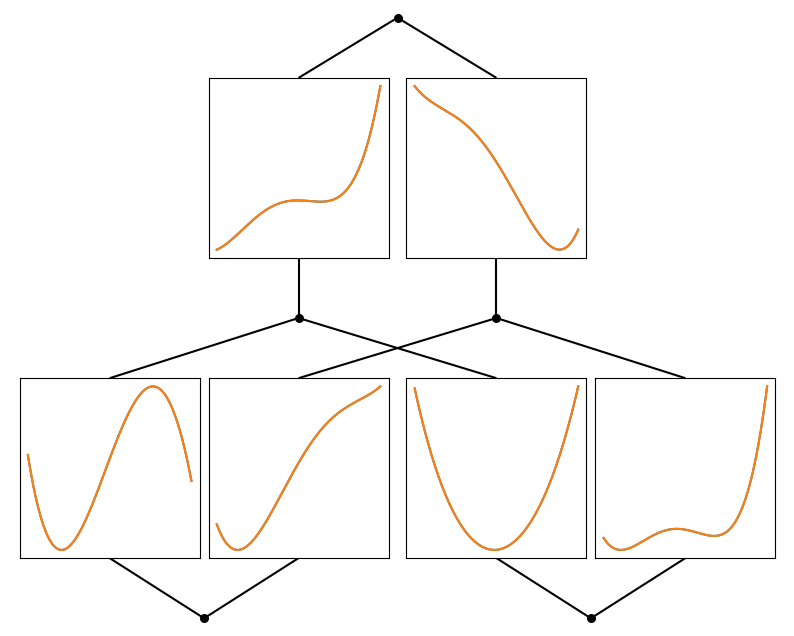

In [7]:
optimizer = torch.optim.Adam(pruned_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 500
for epoch in range(epochs):
    pruned_model.train()
    y_pred = pruned_model(x_train).squeeze(-1)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if epoch % 10 == 0 or epoch == epochs - 1:
        pruned_model.eval()
        with torch.no_grad():
            y_pred = pruned_model(x_val).squeeze(-1)
            val_loss = criterion(y_pred, y_val)
        print(f"\rEpoch {epoch+1:4d}: loss {loss.item():.3e} - val_loss {val_loss.item():.3e}", end="")
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
c = ax1.scatter(x_val[:, 0], x_val[:, 1], c=y_val)
fig.colorbar(c, ax=ax1)
ax1.set_title("Ground Truth")
c = ax2.scatter(x_val[:, 0], x_val[:, 1], c=y_pred)
fig.colorbar(c, ax=ax2)
ax2.set_title("KAN Prediction")
plt.show()

fig = plt.figure(figsize=(10, 8))
plot_kan(pruned_model, node_positions='compact')
plt.show()